In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\heythere\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("../03-Convolutional-Neural-Networks/MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
tf.reset_default_graph() 

In [17]:
# DEFINE parameters
num_inputs = 784 # 28*28
neurons_hid1 = 392
neurons_hid2 = 196
neurons_hid3 = 98
neurons_hid4 = 49
neurons_hid5 = 25
neurons_hid6 = 12
neurons_hid7 = 6
neurons_hid8 = 3
neurons_hid9 = 2
neurons_hid10 = 1

learning_rate = 0.001

In [18]:
# PINV(PSEUDO-INVERSE) function
def pinv(a, rcond=1e-15):
    s, u, v = tf.svd(a)
    # Ignore singular values close to zero to prevent numerical overflow
    limit = rcond * tf.reduce_max(s)
    non_zero = tf.greater(s, limit)

    reciprocal = tf.where(non_zero, tf.reciprocal(s), tf.zeros(s.shape))
    lhs = tf.matmul(v, tf.diag(reciprocal))
    return tf.matmul(lhs, u, transpose_b=True)

In [19]:
# TRANSPOSE OR PINV
tie_weight = tf.transpose #pinv

In [20]:
## PLACEHOLDER DEFINATION
X = tf.placeholder(tf.float32, shape=[None, num_inputs])

In [29]:
## WEIGHTS DEFINATION
initializer = tf.variance_scaling_initializer()

# w1 = tf.Variable(initializer([num_inputs, neurons_hid1]), dtype=tf.float32)
w1 = tf.Variable(np.load('./save/weights/w1.npy'))
w1_ = tie_weight(w1)

w2 = tf.Variable(np.load('./save/weights/w2.npy'))
w2_ = tie_weight(w2)

w3 = tf.Variable(initializer([neurons_hid2, neurons_hid3]), dtype=tf.float32)
w3_ = tie_weight(w3)

In [30]:
# ACTIVATION FUNCTION  [ lambda X:X  <OR>  tf.nn.relu  ]
act_func = lambda X:X #tf.nn.relu

In [31]:
# LAYER MODELING OF :NN
hid_layer1 = act_func(tf.matmul(X, w1))
hid_layer2 = act_func(tf.matmul(hid_layer1, w2))

hid_layer3 = act_func(tf.matmul(hid_layer2, w3))

hid_layer2_ = act_func(tf.matmul(hid_layer3, w3_))
hid_layer1_ = act_func(tf.matmul(hid_layer2_,w2_))

output_layer = tf.matmul(hid_layer1_, w1_)

In [32]:
# LOSS FUNCTIONS
loss = tf.reduce_mean(tf.square(output_layer - X))
# loss = tf.reduce_mean(tf.abs(output_layer - X))
# cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=yout))

In [33]:
# TRAINING
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss, var_list=[w3])

In [34]:
# PREPARATION
init = tf.global_variables_initializer()
saver = tf.train.Saver() 

In [36]:
num_epochs = 100
batch_size = 150

try:
    with tf.Session() as sess:
        sess.run(init)

        # Epoch == Entire Training Set
        for epoch in range(num_epochs):
            num_batches = mnist.train.num_examples // batch_size

            # 150 batch size
            for iteration in range(num_batches):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                sess.run(train, feed_dict={X: X_batch})

            training_loss = loss.eval(feed_dict={X: X_batch})   
            print("Epoch {} Complete. Training Loss: {}".format(epoch,training_loss))
            saver.save(sess, "./save/ae_3_98.ckpt")      
except KeyboardInterrupt:
    print('Keyboard Interrupted')
finally:
    print('Finished Training the Model')

Epoch 0 Complete. Training Loss: 0.007908464409410954
Epoch 1 Complete. Training Loss: 0.006913019344210625
Epoch 2 Complete. Training Loss: 0.006186328362673521
Epoch 3 Complete. Training Loss: 0.006460320204496384
Epoch 4 Complete. Training Loss: 0.006097078323364258
Epoch 5 Complete. Training Loss: 0.006457277573645115
Epoch 6 Complete. Training Loss: 0.00606173649430275
Epoch 7 Complete. Training Loss: 0.005750393960624933
Keyboard Interrupted
Finished Training the Model


In [45]:
num_test_images = 10
start_point = 15
with tf.Session() as sess:
    
    saver.restore(sess,"./save/ae_3_98.ckpt")
    
    results,compressed = sess.run([output_layer, hid_layer1],
                                  feed_dict={X:mnist.test.images[start_point:num_test_images+start_point]})
    weight3 = w3.eval()

INFO:tensorflow:Restoring parameters from ./save/ae_3_98.ckpt


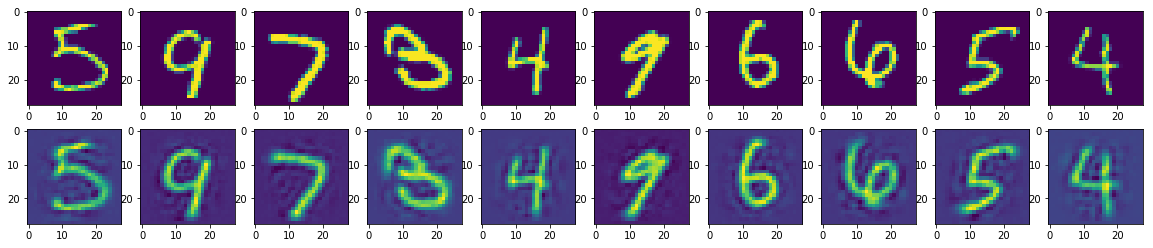

In [46]:
# ORIGINAL VS RECONSTRUCTED
f, a = plt.subplots(2, num_test_images, figsize=(20, 4))
for i in range(start_point,num_test_images+start_point):
    j = i-start_point
    a[0][j].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][j].imshow(np.reshape(results[j], (28, 28)))

In [42]:
print(weight3.shape)
np.save('./save/weights/w3.npy',weight3)
#wt1 = np.load('./save/weights/w1.npy')

(196, 98)
